<a href="https://colab.research.google.com/github/samueleborgognoni/kmeans_nn_ILF_london_smart_meters/blob/main/5_Cyber_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cyber attacks simulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [40]:
from google.colab import drive
drive.mount('/content/drive')

drive_folder_path = '/content/drive/MyDrive/-Career📚/_UNIVERSITY/__Macchine_ed_azionamenti_elettrici/_Progetto_MAE/mae_proj/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# Import previously extracted data for CLUSTER 0
X_ilf_train = pd.read_csv(drive_folder_path + 'data/X_ilf_train.csv')
X_ilf_test = pd.read_csv(drive_folder_path + 'data/X_ilf_test.csv')
y_ilf_train = pd.read_csv(drive_folder_path + 'data/y_ilf_train.csv')
y_ilf_test = pd.read_csv(drive_folder_path + 'data/y_ilf_test.csv')

test_predictions = pd.read_csv(drive_folder_path + 'data/test_predictions.csv')



In [54]:
y_ilf_test.drop(columns=y_ilf_test.columns[0], inplace=True)
y_ilf_train.drop(columns=y_ilf_train.columns[0], inplace=True)

# Convert 'tstp' cols to datetime
y_ilf_train['tstp'] = pd.to_datetime(y_ilf_train['tstp'])
y_ilf_test['tstp'] = pd.to_datetime(y_ilf_test['tstp'])

In [123]:
def simulate_attacks(data, attack_type='scaling', ti=0, te=200,
                     ks=0.4, kr=0.02, kd=0.3):

    df_attacked = data.copy().reset_index(drop=True)

    mask = (df_attacked.index >= ti) & (df_attacked.index < te)

    if attack_type == 'scaling':
        df_attacked.loc[mask, 'energy(kWh)'] *= (1 + ks)

    elif attack_type == 'ramping':
        mid = (ti + te) // 2

        up_mask = (df_attacked.index >= ti) & (df_attacked.index < mid)
        down_mask = (df_attacked.index >= mid) & (df_attacked.index < te)

        df_attacked.loc[up_mask, 'energy(kWh)'] *= (
            1 + kr * np.linspace(0, 1, up_mask.sum())
        )

        df_attacked.loc[down_mask, 'energy(kWh)'] *= (
            1 - kr * np.linspace(0, 1, down_mask.sum())
        )

    elif attack_type == 'random':
        noise = kd * np.random.rand(mask.sum())
        df_attacked.loc[mask, 'energy(kWh)'] += noise

    return df_attacked



def apply_attacks_per_meter(df, attack_type='scaling', ti=100, te=200,
                            ks=0.4, kr=0.1, kd=0.3):

    attacked_list = []

    for lclid, df_meter in df.groupby('LCLid'):
        df_meter = df_meter.sort_values('tstp')  # importantissimo
        df_attacked = simulate_attacks(
            df_meter,
            attack_type=attack_type,
            ti=ti,
            te=te,
            ks=ks,
            kr=kr,
            kd=kd
        )
        attacked_list.append(df_attacked)

    return pd.concat(attacked_list).sort_index()



def create_mixed_random_attacks(df, ti=0, te=100, ks=0.2, kr=0.1, kd=0.3, segment_length=400):

    attacked_list = []

    # Group samples by smart meters and iterate for each one
    for lclid, df_meter in df.groupby('LCLid'):
        df_meter = df_meter.sort_values('tstp')
        df_attacked_meter = df_meter.copy()

        # Iterate for each segment
        for start in range(0, len(df_meter), segment_length):
            end = start + segment_length
            # Select the segment of each smart mete
            seg = df_meter.iloc[start:end]
            # Randomly choose the attack method
            attack_type = np.random.choice(['scaling', 'ramping', 'random'])
            # Simulate attack on the chosen segment
            seg_attacked = simulate_attacks(
                seg,
                attack_type=attack_type,
                ti=ti,
                te=min(te, len(seg)),
                ks=ks,
                kr=kr,
                kd=kd)
            df_attacked_meter.iloc[start:end] = seg_attacked.values

        df_attacked_meter['LCLid'] = lclid
        attacked_list.append(df_attacked_meter)

    return pd.concat(attacked_list, ignore_index=True) # ignore_index to avoid duplicates


In [124]:
# Simulate moxed attacks and get the dataframe
y_ilf_test_attacked = create_mixed_random_attacks(y_ilf_test)

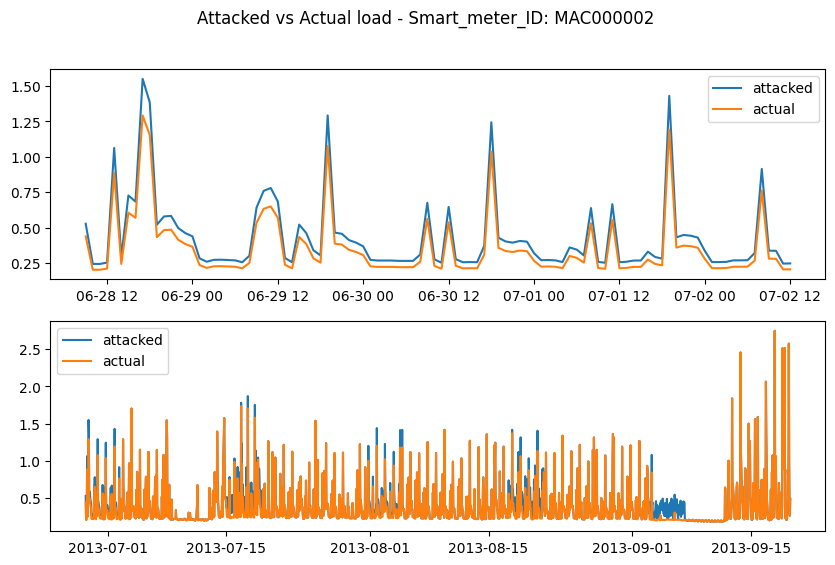

In [126]:
meter_id = 'MAC000002' # <-- choose a meter LCLid
y_ilf_test_attacked_meter = y_ilf_test_attacked[y_ilf_test_attacked['LCLid'] == meter_id]
y_ilf_test_meter = y_ilf_test[y_ilf_test['LCLid'] == meter_id]

# Plot to show the attacks for the chosen meter in a time window
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(y_ilf_test_attacked_meter['tstp'][:100], y_ilf_test_attacked_meter['energy(kWh)'][:100],label='attacked')
plt.plot(y_ilf_test_meter['tstp'][:100], y_ilf_test_meter['energy(kWh)'][:100],label='actual')
plt.legend()

plt.subplot(2,1,2)
plt.plot(y_ilf_test_attacked_meter['tstp'][:2000], y_ilf_test_attacked_meter['energy(kWh)'][:2000],label='attacked')
plt.plot(y_ilf_test_meter['tstp'][:2000], y_ilf_test_meter['energy(kWh)'][:2000],label='actual')
plt.legend()
plt.suptitle(f'Attacked vs Actual load - Smart_meter_ID: {meter_id}')
plt.show()

In [127]:
y_ilf_test_attacked.to_csv(drive_folder_path + 'data/y_ilf_test_attacked.csv', index=False)